<a href="https://colab.research.google.com/github/BountyHunter1999/Learning-PyTorch-Notebooks/blob/main/7_CNN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Sequential Models
# model = nn.Sequential(
#     nn.Linear(784, 128),
#     nn.ReLU(),
#     nn.Linear(128, 10)
# )

In [2]:
# # Build class models
# class ANN(nn.Module):
#   def __init__(self):
#     super(ANN, self).__init__()
#     self.layer1 = Linear(784, 128)
#     self.layer2 = ReLU()
#     self.layer3 = Linear(128, 10)

#   def forward(self, x):
#     x = self.layer1(x)
#     x = self.layer2(x)
#     x = self.layer3(x)
#     return x

# model = ANN()

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [5]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [6]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [7]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [8]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
test_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [10]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [11]:
# Define the model
class CNN(nn.Module):
  def __init__(self, x):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 * 2 * 2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K),
    )

  def forward(self, X):
    # X  torch.Size([128, 1, 28, 28])
    out = self.conv_layers(X) # torch.Size([128, 128, 2, 2])
    # 0 is batch size, N samples in should have N samples out
    out = out.view(out.size(0), -1) # results torch.Size([128, 512])
    out = self.dense_layers(out)
    return out



In [12]:
# Instantiate the model
model = CNN(K) # no. of classes passed

In [13]:
# The same model! But using Flatten
# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2), 
#     nn.ReLU(),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#     nn.ReLU(),
#     nn.Flatten(),
#     nn.Dropout(0.2),
#     nn.Linear(128 * 2 * 2, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, K),
# )

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
# Data Loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [17]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data into GPU if available
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs) # calls the forward function
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      # train_loss over each iteration
      train_loss.append(loss.item())

    # Get train and test loss

    # this mean gives the train_loss over a epoch
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item()) # iteration test loss
    test_loss = np.mean(test_loss) # epochs test loss

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch: {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
    
  return train_losses, test_losses


In [18]:
# CPU Took Duration: 0:00:31.26
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch: 1/15, Train Loss: 0.6512,       Test Loss: 0.5019, Duration: 0:00:17.579242
Epoch: 2/15, Train Loss: 0.4324,       Test Loss: 0.4238, Duration: 0:00:12.666878
Epoch: 3/15, Train Loss: 0.3726,       Test Loss: 0.4003, Duration: 0:00:14.835914
Epoch: 4/15, Train Loss: 0.3352,       Test Loss: 0.3545, Duration: 0:00:16.148711
Epoch: 5/15, Train Loss: 0.3093,       Test Loss: 0.3415, Duration: 0:00:16.657149
Epoch: 6/15, Train Loss: 0.2856,       Test Loss: 0.3284, Duration: 0:00:15.610459
Epoch: 7/15, Train Loss: 0.2683,       Test Loss: 0.3234, Duration: 0:00:12.706660
Epoch: 8/15, Train Loss: 0.2510,       Test Loss: 0.3126, Duration: 0:00:12.603229
Epoch: 9/15, Train Loss: 0.2381,       Test Loss: 0.3224, Duration: 0:00:12.709349
Epoch: 10/15, Train Loss: 0.2211,       Test Loss: 0.3147, Duration: 0:00:12.912969
Epoch: 11/15, Train Loss: 0.2084,       Test Loss: 0.3199, Duration: 0:00:12.818557
Epoch: 12/15, Train Loss: 0.1986,       Test Loss: 0.3032, Duration: 0:00:12.899004
E

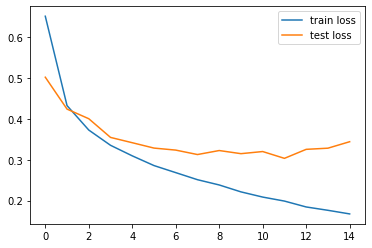

In [19]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [22]:
targets.shape, targets.shape[0]

(torch.Size([96]), 96)

In [23]:
# Accuracy 

n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction 
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1) # max_values and its argument

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")


Train acc: 0.9434, Test acc: 0.8946


In [25]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
  """
  This Function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = ".2f" if normalize  else "d"
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()


Confusion matrix, without normalization
[[878   1  21  24   1   1  72   0   2   0]
 [  2 975   1  15   2   0   3   0   2   0]
 [ 22   0 860  12  46   0  60   0   0   0]
 [ 12   5  13 935  17   0  18   0   0   0]
 [  1   2  64  32 820   0  80   0   1   0]
 [  0   0   0   1   0 981   0  17   0   1]
 [143   2  70  39  82   1 656   0   7   0]
 [  0   0   0   0   0  12   0 968   0  20]
 [  6   1   6   5   5   5   8   5 959   0]
 [  1   0   0   0   0  10   0  42   0 947]]


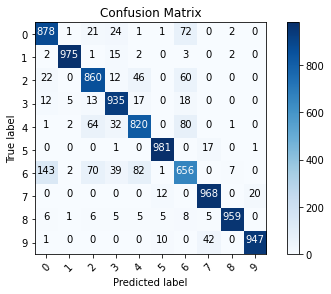

In [29]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [31]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bad
Ankle boot'''.split("\n")

Text(0.5, 1.0, 'True label: T-shirt/top Predicted: Shirt')

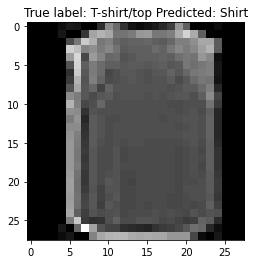

In [33]:
# Show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
plt.title(f"True label: {labels[y_test[i]]} Predicted: {labels[p_test[i]]}")